 # Lab 3 - 2D → 3D inference 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations
import cv2
%matplotlib notebook

In [2]:
#Read the image
img = Image.open('rectangle.tif')

In [3]:
type(img)

PIL.TiffImagePlugin.TiffImageFile

## Select 2 sets of parallel lines
To select 2 sets of parallel lines, execute the cell and click twice on the figure to create a line between two points. You can do this as many times for the first set of parallel lines you want to include. 

Once you are done with the first set, click once on the right mouse button to start selecting the lines for the second set. 

The two set of parallel lines should appear in red and blue. If you want to start again you can re-execute the cell. 

Once you are done, just go to thhe next cell (without reexecuting the current one)

x, y = [], [] # lists of the ends points of the first set of lines are stored
x2, y2 = [], [] # lists  of the ends points of the second set of lines
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(img.rotate(180), origin='lower', cmap='gray') # set the axis-origin to lower for better understandability (and rotate image)
first_set = True

def onclick(event):
    global first_set
    if event.button == 3: # right click
        first_set = False
    
    if event.button == 1: # mouse click for first set
        if first_set:
            x.append(event.xdata) # store x and y for the clicked point
            y.append(event.ydata)
        else:
            x2.append(event.xdata)
            y2.append(event.ydata)
    for i in range(0, len(x), 2): # plot lines between points pairs
        ax.plot(x[i:i+2], y[i:i+2], 'ro-')
    for i in range(0, len(x2), 2): # plot lines between points pairs
        ax.plot(x2[i:i+2], y2[i:i+2], 'bo-')
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

### COMPUTE VANISHING LANES
We are using the Canny edge detector and the Hough transform for this purpose (more accurate vanishing points)

In [4]:
# Reading the image
img2 = cv2.imread('rectangle.tif')
img2 = np.flip(img2)
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

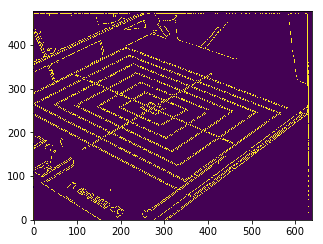

In [5]:
# Canny edge detector
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

plt.figure(figsize=(5, 5))
plt.imshow(edges, origin='lower')

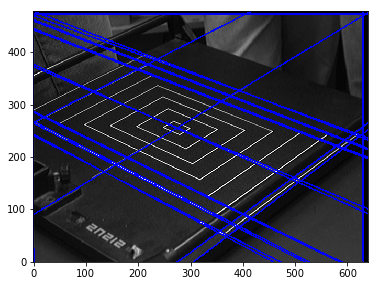

In [6]:
# We use Hough transform to find the lines
lines = cv2.HoughLines(edges, 1, np.pi /180, 200,min_theta=np.pi/4, max_theta=np.pi*2)

img2 = cv2.imread('rectangle.tif')
img2 = cv2.flip(img2, -1)

for line in lines: #For printing the lanes
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho

    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))

    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))

    lanes1 = cv2.line(img2, (x1,y1), (x2,y2), (0,0,255), 2)

plt.figure(figsize=(6, 6))
plt.imshow(lanes1, origin='lower')

#### We dont want the vertical lanes or horizontal (no vanishing points)

In [7]:
lines = cv2.HoughLines(edges, 1, np.pi /180, 200)

img2 = cv2.imread('rectangle.tif')
img2 = cv2.flip(img2, -1)

#Lets store the values
x_values = np.array([])
y_values = np.array([])

set_lanes_left = []
set_lanes_right = []

for line in lines: #For printing the lanes
    rho, theta = line[0]
    if theta < 0.2:
        continue
        
    if theta < (np.pi*1.1) and theta > (np.pi*0.9):
        continue
        
    if theta < (np.pi*3/2*1.2) and theta > (np.pi*3/2*0.8):
        continue
    
    if theta < (np.pi/2*1.2) and theta > (np.pi/2*0.8):
        continue
        
    if theta < np.pi /2:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))

        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        x_values = [[x1, x2]]
        y_values = [[y1, y2]]
        
        x_values = np.transpose(x_values)
        y_values = np.transpose(y_values)
        
        set_lanes_left.append(np.concatenate((x_values, y_values), axis=1))
        continue
    
    if theta > np.pi /2:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))

        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        x_values = [[x1, x2]]
        y_values = [[y1, y2]]
        
        x_values = np.transpose(x_values)
        y_values = np.transpose(y_values)
        
        set_lanes_right.append(np.concatenate((x_values, y_values), axis=1))
        continue

#### Final lines used

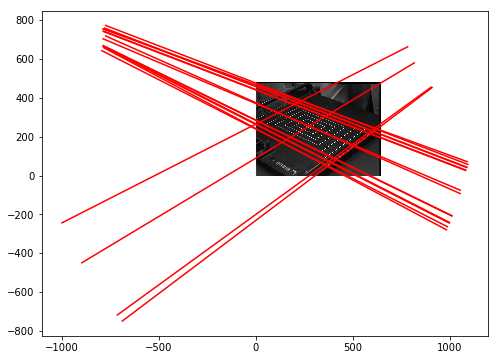

In [8]:
plt.figure(figsize=(8, 8))
plt.imshow(img2, origin='lower')

for i in range(len(set_lanes_left)):
    plt.plot(set_lanes_left[i][:,0],set_lanes_left[i][:,1], 'r', linestyle="-")
    
for i in range(len(set_lanes_right)):
    plt.plot(set_lanes_right[i][:,0],set_lanes_right[i][:,1], 'r', linestyle="-")

#plt.savefig('foo.png')
plt.show()

### LETS MAKE LINES LONGER FOR THE INTERSECTIONS POINTS
### Lefts lines

(0, 2000)

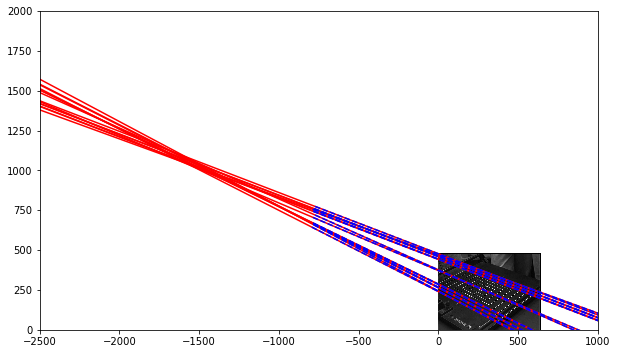

In [9]:
x = range(-100000,1000,1)
plt.figure(figsize=(10, 10))
img2 = cv2.imread('rectangle.tif')
img2 = cv2.flip(img2, -1)
plt.imshow(img2, origin='lower')

for item in set_lanes_left:
    fit= np.polyfit(item[:,0],item[:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")

for i in range(len(set_lanes_left)):
    plt.plot(set_lanes_left[i][:,0],set_lanes_left[i][:,1], 'BLUE', linestyle="--")
  
#for i in range(len(points)):
 #   plt.plot(points[i][0], points[i][1], 'o', color='black')

plt.xlim(-2500, 1000)
plt.ylim(0, 2000)

(0, 1500)

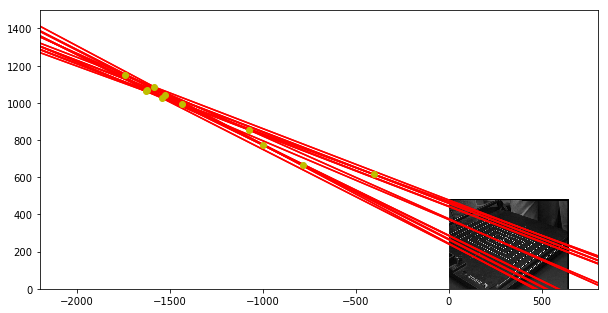

In [10]:
# We obtain the intersection
x = range(-100000,1000,1)
plt.figure(figsize=(10, 10))
img2 = cv2.imread('rectangle.tif')
img2 = cv2.flip(img2, -1)
plt.imshow(img2, origin='lower')

x_points = np.array([])
y_points = np.array([])

for index, item in enumerate(set_lanes_left):
    
    fit= np.polyfit(set_lanes_left[index][:,0],set_lanes_left[index][:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    
    fit= np.polyfit(item[:,0],item[:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")
    
    if index == (len(set_lanes_left)-1):
        index = 0
    else:
        index += 1
            
            
    fit= np.polyfit(set_lanes_left[index][:,0],set_lanes_left[index][:,1],1)
    ang_coeff_1 = fit[0]
    intercept_1 = fit[1]
    
    x_interception = (intercept_1-intercept)/(ang_coeff-ang_coeff_1)
    y_interception = ang_coeff_1*x_interception +intercept_1
    
    x_points= np.concatenate((x_points, x_interception), axis=None)
    y_points= np.concatenate((y_points, y_interception), axis=None)
    
    fit= np.polyfit(set_lanes_left[index][:,0],set_lanes_left[index][:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")
    
plt.plot(x_points,y_points, 'yo')

plt.xlim(-2200, 800)
plt.ylim(-0, 1500)

Intersection point: -1516.4196398488507 1037.0614913970796


(-600, 2500)

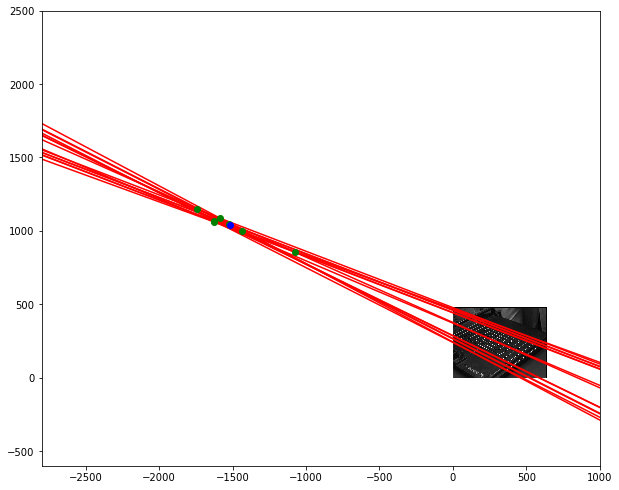

In [11]:
# We clean outliers 
plt.figure(figsize=(10, 10))
img2 = cv2.imread('rectangle.tif')
img2 = cv2.flip(img2, -1)
plt.imshow(img2, origin='lower')

for item in set_lanes_left:
    fit= np.polyfit(item[:,0],item[:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")

for index,item in enumerate(x_points):
    if index>(len(x_points)-1):
        break
    if item < -2000:
        x_points = np.delete(x_points,index)
        y_points = np.delete(y_points,index)
    elif item >-1200:
        x_points = np.delete(x_points,index)
        y_points = np.delete(y_points,index)

for index,item in enumerate(y_points):
    if index>(len(y_points)-1):
        break
    if item < 950:
        x_points = np.delete(x_points,index)
        y_points = np.delete(y_points,index)
    elif item >1200:
        x_points = np.delete(x_points,index)
        y_points = np.delete(y_points,index)
   
x3 =np.mean(x_points)
y3 =np.mean(y_points)


plt.plot(x_points,y_points, 'go')

#plt.scatter(x_points,y_points, 'o', linestyle="-")
print('Intersection point:', x3, y3)
plt.plot(x3, y3, 'bo')
plt.xlim(-2800, 1000)
plt.ylim(-600, 2500)

### RIGHT PART
Again we obtain the intersection of the lines


(0, 1800)

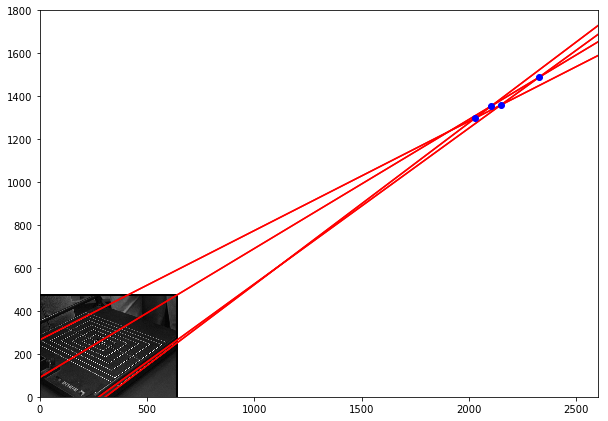

In [12]:
x = range(0,3000,1)
plt.figure(figsize=(10, 10))
img2 = cv2.imread('rectangle.tif')
img2 = cv2.flip(img2, -1)
plt.imshow(img2, origin='lower')

x_points = np.array([])
y_points = np.array([])

for index, item in enumerate(set_lanes_right):
    
    fit= np.polyfit(set_lanes_right[index][:,0],set_lanes_right[index][:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    
    fit= np.polyfit(item[:,0],item[:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")
    
    if index == (len(set_lanes_right)-1):
        index = 0
    else:
        index += 1
            
    fit= np.polyfit(set_lanes_right[index][:,0],set_lanes_right[index][:,1],1)
    ang_coeff_1 = fit[0]
    intercept_1 = fit[1]
    
    x_interception = (intercept_1-intercept)/(ang_coeff-ang_coeff_1)
    y_interception = ang_coeff_1*x_interception +intercept_1
    
    x_points= np.concatenate((x_points, x_interception), axis=None)
    y_points= np.concatenate((y_points, y_interception), axis=None)
    
    fit= np.polyfit(set_lanes_right[index][:,0],set_lanes_right[index][:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")
    
plt.plot(x_points,y_points, 'bo')

plt.xlim(0, 2600)
plt.ylim(0, 1800)

Intersection point: 2094.2964561990616 1337.857070179337


(0, 1800)

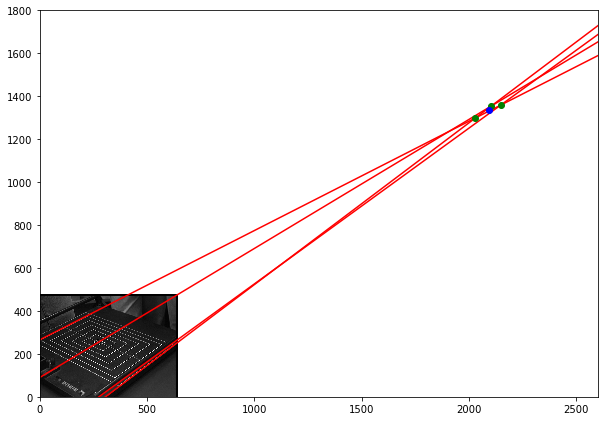

In [13]:
# We use just points 
plt.figure(figsize=(10, 10))
img2 = cv2.imread('rectangle.tif')
img2 = cv2.flip(img2, -1)
plt.imshow(img2, origin='lower')

for item in set_lanes_right:
    fit= np.polyfit(item[:,0],item[:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")

for index,item in enumerate(x_points):
    if index>(len(x_points)-1):
        break
    if item < 1800:
        x_points = np.delete(x_points,index)
        y_points = np.delete(y_points,index)
    elif item >2300:
        x_points = np.delete(x_points,index)
        y_points = np.delete(y_points,index)

for index,item in enumerate(y_points):
    if index>(len(y_points)-1):
        break
    if item < 900:
        x_points = np.delete(x_points,index)
        y_points = np.delete(y_points,index)
    elif item >1500:
        x_points = np.delete(x_points,index)
        y_points = np.delete(y_points,index)
   
x4 =np.mean(x_points)
y4 =np.mean(y_points)

plt.plot(x_points,y_points, 'go')
print('Intersection point:', x4, y4)
plt.plot(x4, y4, 'bo')
plt.xlim(0, 2600)
plt.ylim(0, 1800)

### Vanishing points

In [14]:
#Vanishing point of the leff lines
vanish_left = np.array([x3, y3])
#Vanishing point of the right lines
vanish_right = np.array([x4, y4])

# Method 1
We use the equation of two parallel lines. We know that the dot product of the direction vectors is equal to 0.

w_1 * w_1_prima + w_2 * w_2_prima + w_3 * w_3_prima = 0 

<img src="images/ec1.png">


By replacing we get:

u_inf * + u_inf_prima + v_inf * + v_inf_prima + f^2 = 0

In [15]:
f = np.sqrt(-(vanish_left[0] * vanish_right[0] + vanish_left[1] * vanish_right[1]))
f

1337.3078289495634

In [16]:
# Direction left lanes
u_inf = vanish_left[0]
v_inf = vanish_left[1]
a = np.sqrt(u_inf**2 +v_inf**2 + f**2)

w1_left= 1/a * u_inf
w2_left= 1/a * v_inf
w3_left= 1/a * f

w_left = np.array([w1_left, w2_left, w3_left])

# Direction right lanes
u_inf = vanish_right[0]
v_inf = vanish_right[1]
a = np.sqrt(u_inf**2 +v_inf**2 + f**2)

w1_right= 1/a * u_inf
w2_right= 1/a * v_inf
w3_right= 1/a * f

w_right = np.array([w1_right, w2_right, w3_right])

print('The focal lenght:', f)
print('Diretion vector of lines ending in the left vanish point:',w_left)
print('Diretion vector of lines ending in the right vanish point:',w_right)

The focal lenght: 1337.3078289495634
Diretion vector of lines ending in the left vanish point: [-0.66734558  0.45638976  0.5885221 ]
Diretion vector of lines ending in the right vanish point: [0.74210182 0.4740619  0.47386728]


In [17]:
np.dot(w_left,w_right)

-5.551115123125783e-17

In [18]:
# Normal of the plane
normal_vector = np.cross(w_left, w_right)
print('Normal vector to the plane:', normal_vector)


Normal vector to the plane: [-0.06272773  0.75297656 -0.65505079]


# Method 2

The intersection of the hemisphere with center in teh midpoint between the vanishing poings and the center of the image(optical axis) is the center of projection <br>
https://www.researchgate.net/publication/221297003_Intrinsic_Camera_Calibration_Based_on_Radical_Center_Estimation?enrichId=rgreq-c232f4ce89c853abd365610101661037-XXX&enrichSource=Y292ZXJQYWdlOzIyMTI5NzAwMztBUzoxMDAwNTA3MjIwOTkyMTdAMTQwMDg2NTM2MDAwMg%3D%3D&el=1_x_2&_esc=publicationCoverPdf

(0, 1500)

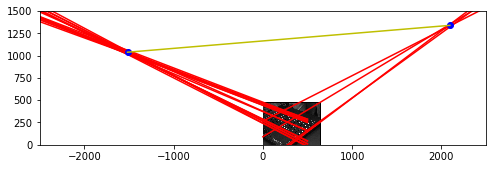

In [19]:
# Once we have both intersection points we put them together
plt.figure(figsize=(8, 8))
img2 = cv2.imread('rectangle.tif')
img2 = cv2.flip(img2, -1)
plt.imshow(img2, origin='lower')


x = range(0,3000,1)
for item in set_lanes_right:
    fit= np.polyfit(item[:,0],item[:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")
    
x = range(-3000,500,1)   
for item in set_lanes_left:
    fit= np.polyfit(item[:,0],item[:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")

plt.plot(x3, y3, 'bo')
plt.plot(x4, y4, 'bo')

plt.plot([x3,x4], [y3,y4], 'y')

plt.xlim(-2500, 2500)
plt.ylim(0, 1500)

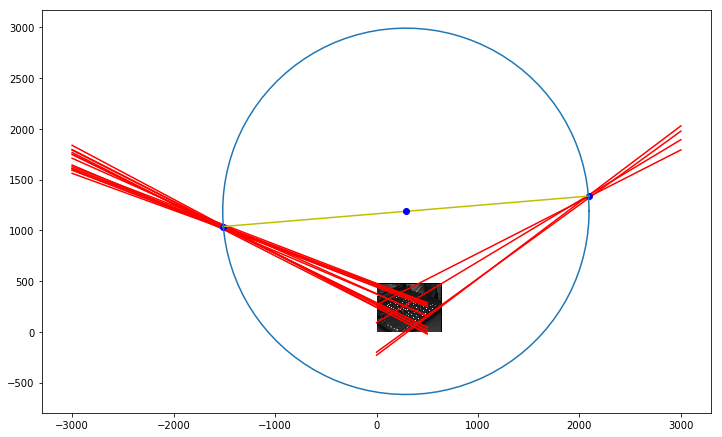

In [20]:
#MIDPOINT

plt.figure(figsize=(12, 12))
img2 = cv2.imread('rectangle.tif')
img2 = cv2.flip(img2, -1)
imarray = np.array(img2)
plt.imshow(imarray, origin='lower')


x1 = (x3+x4)/2
y1 = (y3+y4)/2

x = range(0,3000,1)
for item in set_lanes_right:
    fit= np.polyfit(item[:,0],item[:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")
    
x = range(-3000,500,1)   
for item in set_lanes_left:
    fit= np.polyfit(item[:,0],item[:,1],1)
    ang_coeff = fit[0]
    intercept = fit[1]
    y = ang_coeff * x + intercept
    plt.plot(x,y, 'r', linestyle="-")

plt.plot(x3, y3, 'bo')
plt.plot(x4, y4, 'bo')

plt.plot([x3,x4], [y3,y4], 'y')

plt.plot(x1, y1, 'bo')


# theta goes from 0 to 2pi
theta = np.linspace(0, 2*np.pi, 100)

# the radius of the circle
r = x1-x3
x0=x1
y0=y1

# compute x1 and x2
xc = x0 +  r*np.cos(theta)
yc = y0 + r*np.sin(theta)
plt.plot(xc, yc)
plt.show()

In [21]:
# Outputs

#Vanishing point of the left
vanish_left = np.array([x3, y3])
vanish_right = np.array([x4, y4])
middle_point = np.array([x1, y1])

img_array = np.array(img2)
x_middle_img = (img_array.shape[1])/2
y_middle_img = (img_array.shape[0])/2

middle_image = ([x_middle_img, y_middle_img])

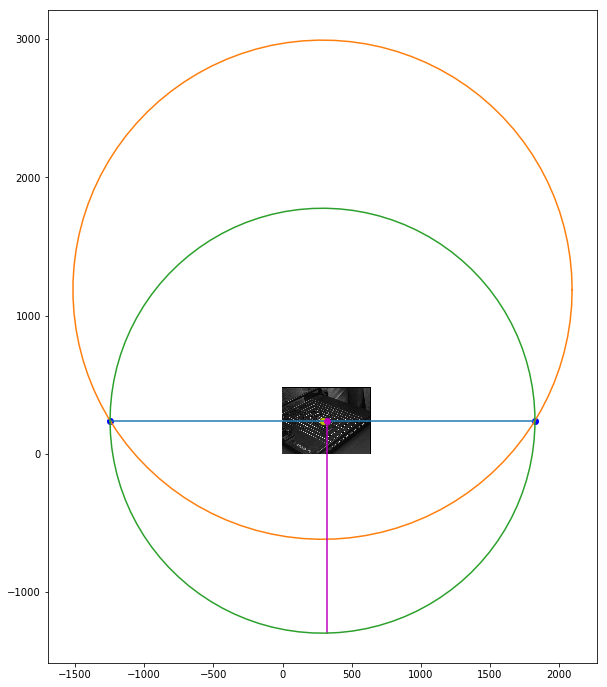

In [22]:
import math
# Intersection magenta line with cicle
theta_y = (y_middle_img - y0)/r
theta = math.asin(theta_y)
theta2 = np.pi- theta

# Point 1
x_intersection = x0 +  r*np.cos(theta)
y_intersection = y0 + r*np.sin(theta)

# Point 2
x_intersection2 = x0 +  r*np.cos(theta2)
y_intersection2 = y0 + r*np.sin(theta2)

# Midle point
x_midle = (x_intersection2 + x_intersection)/2
y_midle = (y_intersection2 + y_intersection)/2

# New circle
theta2 = np.linspace(0, 2*np.pi, 100)

# the radius of the circle
r2 = (x_intersection2 - x_intersection)/2

# compute x1 and x2
xc2 = x_midle +  r2*np.cos(theta2)
yc2 = y_midle + r2*np.sin(theta2)

# Intersection axis of camera with the circle
theta5x = (x_middle_img - x_midle)/r2
theta5 = math.acos(theta5x)
y5 = y_midle + r2*np.sin(theta5)

plt.figure(figsize=(12, 12))
plt.imshow(imarray, origin='lower')
plt.plot(x_intersection, y_intersection, 'bo')
plt.plot(x_intersection2, y_intersection2, 'bo')
plt.plot(x_midle, y_midle, 'yo')
plt.plot([x_intersection,x_intersection2],[y_intersection,y_intersection2])
plt.plot(xc, yc)
plt.plot([x_middle_img, x_middle_img],[y_middle_img, y5], 'm')
plt.plot(xc2, yc2)
plt.plot(x_middle_img, y_middle_img, 'mo')

In [23]:
# Focal lenght
f = y_middle_img- y5

# Direction left lanes
u_inf = vanish_left[0]
v_inf = vanish_left[1]
a = np.sqrt(u_inf**2 +v_inf**2 + f**2)

w1_left= 1/a * u_inf
w2_left= 1/a * v_inf
w3_left= 1/a * f

# Direction right lanes
u_inf = vanish_right[0]
v_inf = vanish_right[1]
a = np.sqrt(u_inf**2 +v_inf**2 + f**2)

w1_right= 1/a * u_inf
w2_right= 1/a * v_inf
w3_right= 1/a * f

print('The focal lenght:', f)

The focal lenght: 1536.448427486736


In [24]:
# Normal of the plane
w_left = np.array([w1_left,w2_left,w3_left])
w_right = np.array([w1_right,w2_right,w3_right])

normal_vector = np.cross(w_left, w_right)

## Calculate focal length f, the direction vectors w1 and w2, and the normal of the planar patch containing the rectangles

### You now have the x and y coordinates of the endpoints of the set of parallel lines you picked previously. You need the coordinates of the vanishing points for both directions.

In [25]:
# Coordinate of the vanishing points (find the intersection between the two set of lines). 
# You can use np.polyfit(x,y,1) which gives you the linear equation y = Ax + B that fit best a set of points
# and find y1 and y2 for the two set of lines --> CALCULATED UP

In [26]:
# Calculate f using the vanishing points --> CALCULATED UP

In [27]:
# The original parline function [TO BE MODIFIED !!!]
# I guess rewriting is having a look anyway
def parlines(lines):
    n = 3 # get 3 dimensions
    f = 1.0 # temporary value
    
    a = np.zeros((lines.shape[0], n)) 
    a[:,0] = lines[:,3] - lines[:,1]
    a[:,1] = -1*(lines[:,2] - lines[:,0])
    a[:,2] = np.multiply(lines[:,1], -1*a[:,1]) - np.multiply(lines[:,0],a[:,0])
    
    u, s, v = np.linalg.svd(a) 
    
    if (v[2] < 0).all(): # s and v are already sorted from largest to smallest
        v_min = np.abs(v[2])
    else:
        v_min = v[2]
        
    wvec = v_min.T
    wvec[0:2] /= f
    wvec /= np.linalg.norm(wvec)

    return wvec

In [28]:
#  Rewritting the x and y coordinates to be read by the parlines function
lines = np.array([x, y]).T.reshape((len(x) // 2, 4)) # reshape to ((x,y), (x,y)) per line
lines2 = np.array([x2, y2]).T.reshape((len(x2) //2 , 4))

TypeError: object of type 'int' has no len()

In [ ]:
# Calculate w1, w2  --> CALCULATED UP

In [ ]:
# Calculate the normal plane --> CALCULATED UP